# Predicting NFL outcomes

In [14]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import copy
import joblib
import pandasql as ps
import numpy_financial

## Data preparation

In [4]:
"""The last year that will be included in the training/validation sets (up to 2023)
If you want to backtest the spread model on 2023 betting data, you should set this to 2022"""

LAST_YEAR = 2022

In [5]:
df = pd.read_csv("scores.csv")

# remove unnecessary columns and rows
columns_to_keep = [
    "Season",
    "Week",
    "HomeTeam",
    "AwayTeam",
    "HomeRecord",
    "AwayRecord",
    "HomeScore",
    "AwayScore",
]

teams_to_remove = [
    "Football Team",
    "Football",
    "HomeTeam_AFC Pro Bowl",
    "HomeTeam_NFC Pro Bowl",
    "AwayTeam_AFC Pro Bowl",
    "AwayTeam_NFC Pro Bowl",
]

df = df.replace("Redskins", "Commanders")


# function to remove rows we don't want to train on
def filter_rows_by_values(df, col, values):
    return df[~df[col].isin(values)]


df = df[columns_to_keep]
df = filter_rows_by_values(df, "HomeTeam", teams_to_remove)
df = filter_rows_by_values(df, "AwayTeam", teams_to_remove)
df = filter_rows_by_values(df, "Week", ["Hall Of Fame"])

# split W-L record into columns
df[["HomeWins", "HomeLosses", "HomeDraws"]] = df["HomeRecord"].str.split(
    "-", expand=True
)
df[["AwayWins", "AwayLosses", "AwayDraws"]] = df["AwayRecord"].str.split(
    "-", expand=True
)
df["Spread"] = df["HomeScore"] - df["AwayScore"]

df = df.drop(columns=["HomeRecord", "AwayRecord"])
df.replace(to_replace=[None], value=0, inplace=True)


# helper function to parse week numbers
def inner_parse(row):
    try:
        return int(row.split(" ")[1])
    except ValueError:
        return None


df["WeekNumber"] = df["Week"].map(inner_parse)

for i, row in df.iterrows():
    if row["Spread"] > 0:
        df.at[i, "HomeWins"] = int(row["HomeWins"]) - 1
        df.at[i, "AwayLosses"] = int(row["AwayLosses"]) - 1
    elif row["Spread"] < 0:
        df.at[i, "HomeLosses"] = int(row["HomeLosses"]) - 1
        df.at[i, "AwayWins"] = int(row["AwayWins"]) - 1
    else:
        df.at[i, "HomeDraws"] = int(row["HomeDraws"]) - 1
        df.at[i, "AwayDraws"] = int(row["AwayDraws"]) - 1

df["HomeWin"] = (df["Spread"] > 0).astype(int)
df = df.dropna()

df = df.drop(columns=["Week"])

df_betting_backtest = df.copy().drop(columns=["HomeWin"])

df = df.drop(columns=["HomeScore", "AwayScore"])
df = df[df["Season"] <= LAST_YEAR]
df = df.drop(columns=["Season"])

# Now get dummies
df = pd.get_dummies(df, columns=["HomeTeam", "AwayTeam"], dtype=int)

# shuffle the data to remove time-dependency, this was a huge unlock
df = df.sample(frac=1).reset_index(drop=True)

## Task 1: Predicting the winner of game

In [349]:
outcome_df = df.copy()
outcome_df = outcome_df.drop(columns=["Spread"])

TEST_SPLIT = 0.2

X = outcome_df.drop(columns=["HomeWin"]).values.astype(float)
y = outcome_df[["HomeWin"]].values.astype(float)

X_scaled = preprocessing.normalize(X, axis=0)
Y_scaled = preprocessing.normalize(y)

X = torch.tensor(X_scaled, dtype=torch.float32)
y = torch.clamp(torch.tensor(Y_scaled, dtype=torch.float32), min=0, max=1)

idx = int(len(X) * (1 - TEST_SPLIT))

train_X = X[:idx]
train_y = y[:idx]

test_X = X[idx:]
test_y = y[idx:]

In [355]:
# train the model
outcome_model = nn.Sequential(
    nn.Linear(71, 25), nn.ReLU(), nn.Dropout(0.5), nn.Linear(25, 1), nn.Sigmoid()
)

loss_fn = nn.BCELoss()
optimizer = optim.Adam(outcome_model.parameters(), lr=0.001)

n_epochs = 500
batch_size = 25

last_loss = 0
curr_loss = 10000
epochs = 0
while abs(curr_loss - last_loss) > 1e-6 and epochs < n_epochs:
    epochs += 1

    last_loss = curr_loss
    for i in range(0, len(train_X), batch_size):
        Xbatch = train_X[i : i + batch_size]
        y_pred = outcome_model(Xbatch)
        ybatch = train_y[i : i + batch_size]
        curr_loss = loss_fn(y_pred, ybatch)
        optimizer.zero_grad()
        curr_loss.backward()
        optimizer.step()
    # print(f"Epoch: {epochs}, Loss: {curr_loss}")

y_pred = outcome_model(test_X)
accuracy = (y_pred.round() == test_y).float().mean()
print(f"Accuracy {accuracy:0.2%}")

Accuracy 62.15%


In [356]:
torch.save(outcome_model, "outcome_model.gz")

## Task 2: Predicting the spread between the home and away teams

In [357]:
spread_df = df.copy()
spread_df = spread_df.drop(columns=["HomeWin"])

# separate data into training and eval sets, could probably have done this using train_test_split
TEST_SPLIT = 0.1

X = spread_df.drop(columns=["Spread"]).values.astype(float)
y = spread_df[["Spread"]].values.astype(float)

idx = int(len(X) * (1 - TEST_SPLIT))

X_train_raw = X[:idx]
y_train = y[:idx]

X_test_raw = X[idx:]
y_test = y[idx:]

scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

MSE: 171.80
RMSE: 13.11


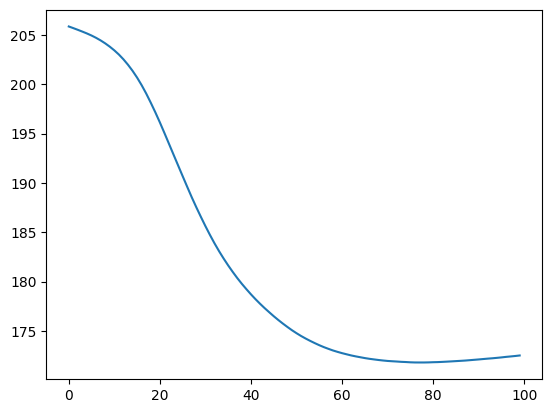

In [358]:
# train the model
spread_model = nn.Sequential(
    nn.Linear(X.shape[1], 16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Linear(8, 1),
)

# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(spread_model.parameters(), lr=0.0001)

n_epochs = 100  # number of epochs to run
batch_size = 16  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

# Hold the best model
best_mse = np.inf  # init to infinity
best_weights = None
history = []

for epoch in range(n_epochs):
    spread_model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start : start + batch_size]
            y_batch = y_train[start : start + batch_size]
            # forward pass
            y_pred = spread_model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    spread_model.eval()
    y_pred = spread_model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(spread_model.state_dict())

# restore model and return best accuracy
spread_model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [359]:
torch.save(spread_model, "spread_model.gz")
joblib.dump(scaler, "scaler.gz")

['scaler.gz']

## Placing 'bets' using our spread model

In [10]:
# How much to bet
BET_AMOUNT = 100

In [6]:
teams = pd.read_csv("teams.csv")
bets = pd.read_csv("bets.csv")

teams = teams.replace("Redskins", "Commanders")
bets = bets.replace("Redskins", "Commanders")

bets = bets[
    [
        "schedule_season",
        "schedule_week",
        "team_home",
        "team_away",
        "score_home",
        "score_away",
        "spread_favorite",
        "team_favorite_id",
    ]
].dropna()
bets = bets[(bets["schedule_season"] == LAST_YEAR + 1)]
bets = bets[(bets["schedule_week"].str.isnumeric())]

bets = bets.merge(teams, left_on="team_favorite_id", right_on="team_id")
bets = ps.sqldf("""
SELECT schedule_season,
                schedule_week,
                team_home as HomeTeam,
                team_away as AwayTeam,
                score_home,
                score_away,
                spread_favorite,
                team_name_short as Favorite
from bets
""")
bets = bets.merge(teams, left_on="HomeTeam", right_on="team_name")
bets = ps.sqldf("""
SELECT schedule_season,
                schedule_week,
                team_name_short as HomeTeam,
                AwayTeam,
                score_home,
                score_away,
                spread_favorite,
                Favorite
from bets
""")
bets = bets.merge(teams, left_on="AwayTeam", right_on="team_name")
bets = ps.sqldf("""
SELECT schedule_season,
                schedule_week,
                HomeTeam,
                team_name_short as AwayTeam,
                score_home,
                score_away,
                spread_favorite,
                Favorite
from bets
""")


def inner_parse(row):
    try:
        return int(row)
    except ValueError:
        return None


bets["WeekNumber"] = bets["schedule_week"].map(inner_parse)

cols = ["schedule_season", "WeekNumber", "HomeTeam", "AwayTeam"]
bets["key"] = bets[cols].apply(lambda row: "_".join(row.values.astype(str)), axis=1)

cols = ["Season", "WeekNumber", "HomeTeam", "AwayTeam"]

df_betting_backtest["WeekNumber"] = df_betting_backtest["WeekNumber"].map(inner_parse)

df_betting_backtest["key"] = df_betting_backtest[cols].apply(
    lambda row: "_".join(row.values.astype(str)), axis=1
)
df_betting_backtest = df_betting_backtest.merge(bets, on="key")

df_betting_backtest = ps.sqldf("""
SELECT WeekNumber_y as WeekNumber,
        HomeTeam_x as HomeTeam,
         AwayTeam_x as AwayTeam,
         HomeScore,
         AwayScore,
         HomeWins,
         HomeLosses,
         HomeDraws,
         AwayWins,
         AwayLosses,
         AwayDraws,
         Favorite,
         spread_favorite as OddsSpread

from df_betting_backtest
""")

In [9]:
spread_model = torch.load("spread_model.gz", weights_only=False)


# helper functions to make a prediction given the model
def predict(
    week,
    home_team,
    home_wins,
    home_losses,
    home_draws,
    away_team,
    away_wins,
    away_losses,
    away_draws,
):
    template = {
        "HomeWins": home_wins,
        "HomeLosses": home_losses,
        "HomeDraws": home_draws,
        "AwayWins": away_wins,
        "AwayLosses": away_losses,
        "AwayDraws": away_draws,
        "WeekNumber": week,
        "HomeTeam_49ers": 0,
        "HomeTeam_Bears": 0,
        "HomeTeam_Bengals": 0,
        "HomeTeam_Bills": 0,
        "HomeTeam_Broncos": 0,
        "HomeTeam_Browns": 0,
        "HomeTeam_Buccaneers": 0,
        "HomeTeam_Cardinals": 0,
        "HomeTeam_Chargers": 0,
        "HomeTeam_Chiefs": 0,
        "HomeTeam_Colts": 0,
        "HomeTeam_Commanders": 0,
        "HomeTeam_Cowboys": 0,
        "HomeTeam_Dolphins": 0,
        "HomeTeam_Eagles": 0,
        "HomeTeam_Falcons": 0,
        "HomeTeam_Giants": 0,
        "HomeTeam_Jaguars": 0,
        "HomeTeam_Jets": 0,
        "HomeTeam_Lions": 0,
        "HomeTeam_Packers": 0,
        "HomeTeam_Panthers": 0,
        "HomeTeam_Patriots": 0,
        "HomeTeam_Raiders": 0,
        "HomeTeam_Rams": 0,
        "HomeTeam_Ravens": 0,
        "HomeTeam_Saints": 0,
        "HomeTeam_Seahawks": 0,
        "HomeTeam_Steelers": 0,
        "HomeTeam_Texans": 0,
        "HomeTeam_Titans": 0,
        "HomeTeam_Vikings": 0,
        "AwayTeam_49ers": 0,
        "AwayTeam_Bears": 0,
        "AwayTeam_Bengals": 0,
        "AwayTeam_Bills": 0,
        "AwayTeam_Broncos": 0,
        "AwayTeam_Browns": 0,
        "AwayTeam_Buccaneers": 0,
        "AwayTeam_Cardinals": 0,
        "AwayTeam_Chargers": 0,
        "AwayTeam_Chiefs": 0,
        "AwayTeam_Colts": 0,
        "AwayTeam_Commanders": 0,
        "AwayTeam_Cowboys": 0,
        "AwayTeam_Dolphins": 0,
        "AwayTeam_Eagles": 0,
        "AwayTeam_Falcons": 0,
        "AwayTeam_Giants": 0,
        "AwayTeam_Jaguars": 0,
        "AwayTeam_Jets": 0,
        "AwayTeam_Lions": 0,
        "AwayTeam_Packers": 0,
        "AwayTeam_Panthers": 0,
        "AwayTeam_Patriots": 0,
        "AwayTeam_Raiders": 0,
        "AwayTeam_Rams": 0,
        "AwayTeam_Ravens": 0,
        "AwayTeam_Saints": 0,
        "AwayTeam_Seahawks": 0,
        "AwayTeam_Steelers": 0,
        "AwayTeam_Texans": 0,
        "AwayTeam_Titans": 0,
        "AwayTeam_Vikings": 0,
    }

    template[f"HomeTeam_{home_team}"] = 1
    template[f"AwayTeam_{away_team}"] = 1

    scaler = joblib.load("scaler.gz")
    X = np.array(list(template.values()), dtype=float).reshape(1, -1)
    X_scaled = scaler.transform(X)
    X = torch.tensor(X_scaled, dtype=torch.float32)
    y_pred = spread_model(X)

    return y_pred


def predict_row(row):
    return (
        predict(
            row["WeekNumber"],
            row["HomeTeam"],
            row["HomeWins"],
            row["HomeLosses"],
            row["HomeDraws"],
            row["AwayTeam"],
            row["AwayWins"],
            row["AwayLosses"],
            row["AwayDraws"],
        )
        .detach()
        .numpy()
        .flatten()[0]
    )

In [11]:
df_betting_backtest["Prediction"] = df_betting_backtest.apply(predict_row, axis=1)
result = df_betting_backtest[
    [
        "WeekNumber",
        "HomeTeam",
        "AwayTeam",
        "Favorite",
        "HomeScore",
        "AwayScore",
        "OddsSpread",
        "Prediction",
    ]
]

result = ps.sqldf("""
         SELECT *,
         CASE 
           WHEN HomeTeam = Favorite THEN -OddsSpread
           ELSE OddsSpread
       END AS HomeSpread,
                  HomeScore - AwayScore AS ActualSpread
FROM result
""")
result = ps.sqldf("""
         SELECT *,
         CASE 
           WHEN Sign(Prediction) = Sign(HomeSpread) AND Abs(Prediction) >= Abs(HomeSpread) THEN 1
           ELSE 0
       END AS Bet
FROM result
""")
result = ps.sqldf(f"""
         SELECT 
         *,
         {BET_AMOUNT}*Bet AS BetAmount
FROM result
""")
result = ps.sqldf("""
         SELECT 
         *,
          (BetAmount + BetAmount / 100.0 * 110.0)*(Sign(ActualSpread) = Sign(HomeSpread) AND Abs(ActualSpread) >= Abs(ActualSpread)) AS Payout
FROM result
""")

## Backtesting the betting model

In [15]:
bet_amount = result["BetAmount"].sum()
payout = result["Payout"].sum()
profit = payout - bet_amount
MOIC = payout / bet_amount

curr_format = lambda x: "{:0,.2f}".format(float(x))
output = f"Bet: ${curr_format(bet_amount)}\nPayout: ${curr_format(payout)}\nProfit: ${curr_format(profit)}\nMOIC: {"{:0,.2f}".format(MOIC)}x"
print(output)
irr = (
    result[["WeekNumber", "BetAmount", "Payout"]]
    .groupby("WeekNumber")
    .sum()
    .reset_index()
)
bet_amount = irr["BetAmount"].sum()
irr = list(irr["Payout"])
irr.reverse()
irr.append(bet_amount * -1)
irr.reverse()
r = numpy_financial.irr(irr)
r = (1 + r) ** 52 - 1

print(f"IRR: {r*100:0,.2f}%")

Bet: $11,700.00
Payout: $17,430.00
Profit: $5,730.00
MOIC: 1.49x
IRR: 677.81%


### Make a single bet prediction

In [25]:
Week = 2

Home = "Packers"
HomeWins = 0
HomeLosses = 1
HomeDraws = 0

Away = "Colts"
AwayWins = 0
AwayLosses = 1
AwayDraws = 0

prediction = (
    predict(
        Week,
        Home,
        HomeWins,
        HomeLosses,
        HomeDraws,
        Away,
        AwayWins,
        AwayLosses,
        AwayDraws,
    )
    .detach()
    .numpy()
    .flatten()[0]
)

if prediction < 0:
    print(f"{Away} beat {Home} by {-1*prediction:0.2f} pts")
elif prediction > 0:
    print(f"{Home} beat {Away} by {prediction:0.2f} pts")
else:
    print(f"{Away} and {Home} tie")

Packers beat Colts by 1.69 pts


### Evaluate betting profit over a single week's results

In [28]:
Week = 2

data = [
    "Bills 1-0-0 Dolphins 1-0-0 Bills 2.5 COVER",
    "Raiders 0-1-0 Ravens 0-1-0 Raiders 9 COVER",
    "Chargers 1-0-0 Panthers 0-1-0 Chargers -4.5 COVER",
    "Saints 1-0-0 Cowboys 1-0-0 Saints 6 COVER",
    "Buccaneers 1-0-0 Lions 1-0-0 Buccaneers 7.5 COVER",
    "Colts 0-1-0 Packers 0-1-0 Packers 2.5 COVER",
    "Browns 0-1-0 Jaguars 0-1-0 Browns 3 COVER",
    "49ers 1-0-0 Vikings 1-0-0 Vikings 4 COVER",
    "Seahawks 1-0-0 Patriots 1-0-0 Seahawks 3 COVER",
    "Jets 0-1-0 Titans 0-1-0 Jets -3.5 COVER",
    "Giants 0-1-0 Commanders 0-1-0 Commanders -1.5 COVER",
    "Rams 0-1-0 Cardinals 0-1-0 Arizona 0 COVER",
    "Bengals 0-1-0 Chiefs 1-0-0 Chiefs 6.5 COVER",
    "Steelers 1-0-0 Broncos 0-1-0 Steelers -2.5 COVER",
    "Bears 1-0-0 Texans 1-0-0 Bears 6.5 COVER",
    "Falcons 0-1-0 Eagles 1-0-0 Falcons 5.5 COVER",
]

proceeds = 0
outflow = 0

for row in data:
    args = row.split(" ")
    Away = args[0]
    AwayWins = int(args[1].split("-")[0])
    AwayLosses = int(args[1].split("-")[1])
    AwayDraws = int(args[1].split("-")[2])

    Home = args[2]
    HomeWins = int(args[3].split("-")[0])
    HomeLosses = int(args[3].split("-")[1])
    HomeDraws = int(args[3].split("-")[2])

    favorite = args[4]
    spread = float(args[5])
    result = args[6]

    if favorite != Home:
        spread = spread * -1

    prediction = (
        predict(
            Week,
            Home,
            HomeWins,
            HomeLosses,
            HomeDraws,
            Away,
            AwayWins,
            AwayLosses,
            AwayDraws,
        )
        .detach()
        .numpy()
        .flatten()[0]
    )

    guess = "ATS"

    if prediction < 0 and spread < 0 and prediction < spread:
        print(f"{Away} vs. {Home}: {prediction:0.2f} {spread} COVER")
        guess = "COVER"
    elif prediction > 0 and spread > 0 and prediction > spread:
        print(f"{Away} vs. {Home}: {prediction:0.2f} {spread} COVER")
        guess = "COVER"
    else:
        print(f"{Away} vs. {Home}: {prediction:0.2f} {spread} NO BET")

    if guess == "COVER" and guess == result:
        outflow += 10
        proceeds += 11 + outflow

print(outflow, proceeds)

Bills vs. Dolphins: -2.69 -2.5 COVER
Raiders vs. Ravens: 10.94 -9.0 NO BET
Chargers vs. Panthers: -3.55 4.5 NO BET
Saints vs. Cowboys: -0.38 -6.0 NO BET
Buccaneers vs. Lions: -4.66 -7.5 NO BET
Colts vs. Packers: 1.69 2.5 NO BET
Browns vs. Jaguars: 0.20 -3.0 NO BET
49ers vs. Vikings: -4.28 4.0 NO BET
Seahawks vs. Patriots: -1.03 -3.0 NO BET
Jets vs. Titans: 7.31 3.5 COVER
Giants vs. Commanders: -3.65 -1.5 COVER
Rams vs. Cardinals: -8.89 -0.0 NO BET
Bengals vs. Chiefs: 6.69 6.5 COVER
Steelers vs. Broncos: -0.60 2.5 NO BET
Bears vs. Texans: -0.52 -6.5 NO BET
Falcons vs. Eagles: 5.65 -5.5 NO BET
40 144
